In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
mps_device = torch.device("mps")

In [3]:
data = [
    ("this is a positive example", 1),
    ("this is a negative example", 0),
    ("I absolutely love this product", 1),
    ("I really dislike this product", 0),
    ("the movie was fantastic and inspiring", 1),
    ("the movie was dull and disappointing", 0),
    ("what an amazing experience", 1),
    ("what a terrible experience", 0),
    ("the food was delicious and well-prepared", 1),
    ("the food was awful and undercooked", 0),
    ("I enjoyed the service and the atmosphere", 1),
    ("I was frustrated by the poor service", 0),
    ("the performance was outstanding", 1),
    ("the performance was mediocre", 0)
]

In [21]:
def tokenize(text):
    return text.lower().split()

def build_vocab(data):
    vocab = {"<PAD>": 0, "<UNK>": 1}
    idx = 2
    for text, _ in data:
        for token in tokenize(text):
            if token not in vocab:
                vocab[token] = idx
                idx += 1
    return vocab

def text_to_sequence(text, vocab):
    tokens = tokenize(text)
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

def cosine_similarity(embedding1, embedding2):
    return F.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0)).item()

In [5]:
vocab = build_vocab(data)
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

Vocabulary size: 41


In [6]:
class TextDataset(Dataset):
    def __init__(self, data, vocab, max_length=10):
        self.data = data
        self.vocab = vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text, label = self.data[idx]
        seq = text_to_sequence(text, self.vocab)
        if len(seq) < self.max_length:
            seq = seq + [self.vocab["<PAD>"]] * (self.max_length - len(seq))
        else:
            seq = seq[:self.max_length]
        return torch.tensor(seq, dtype=torch.long), torch.tensor(label, dtype=torch.float)


dataset = TextDataset(data, vocab, max_length=10)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [7]:
class SupervisedEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=32, hidden_dim=16):
        super(SupervisedEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, 
                                      embedding_dim=embedding_dim, 
                                      padding_idx=0)
        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        # Create a mask for non-padding tokens (PAD index is 0)
        mask = (x != 0).unsqueeze(-1).float()
        summed = torch.sum(embedded * mask, dim=1)
        lengths = torch.sum(mask, dim=1)  # Number of valid tokens
        avg_embedded = summed / lengths.clamp(min=1)
        
        hidden = self.relu(self.fc(avg_embedded))
        output = self.out(hidden)
        return output.squeeze(1)  # (batch_size,)
    
embedding_dim = 32
hidden_dim = 16
model = SupervisedEmbeddingModel(vocab_size, embedding_dim, hidden_dim)

In [8]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 30
epoch_losses = []  # список для хранения средней потери по эпохам


for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    print(f"Эпоха {epoch+1}/{num_epochs}, Потеря: {avg_loss:.4f}")

Эпоха 1/30, Потеря: 0.5808
Эпоха 2/30, Потеря: 0.5734
Эпоха 3/30, Потеря: 0.5667
Эпоха 4/30, Потеря: 0.5581
Эпоха 5/30, Потеря: 0.5505
Эпоха 6/30, Потеря: 0.5418
Эпоха 7/30, Потеря: 0.5327
Эпоха 8/30, Потеря: 0.5238
Эпоха 9/30, Потеря: 0.5151
Эпоха 10/30, Потеря: 0.5051
Эпоха 11/30, Потеря: 0.4964
Эпоха 12/30, Потеря: 0.4858
Эпоха 13/30, Потеря: 0.4738
Эпоха 14/30, Потеря: 0.4620
Эпоха 15/30, Потеря: 0.4508
Эпоха 16/30, Потеря: 0.4399
Эпоха 17/30, Потеря: 0.4273
Эпоха 18/30, Потеря: 0.4166
Эпоха 19/30, Потеря: 0.4028
Эпоха 20/30, Потеря: 0.3905
Эпоха 21/30, Потеря: 0.3778
Эпоха 22/30, Потеря: 0.3653
Эпоха 23/30, Потеря: 0.3523
Эпоха 24/30, Потеря: 0.3395
Эпоха 25/30, Потеря: 0.3274
Эпоха 26/30, Потеря: 0.3162
Эпоха 27/30, Потеря: 0.3033
Эпоха 28/30, Потеря: 0.2916
Эпоха 29/30, Потеря: 0.2802
Эпоха 30/30, Потеря: 0.2690


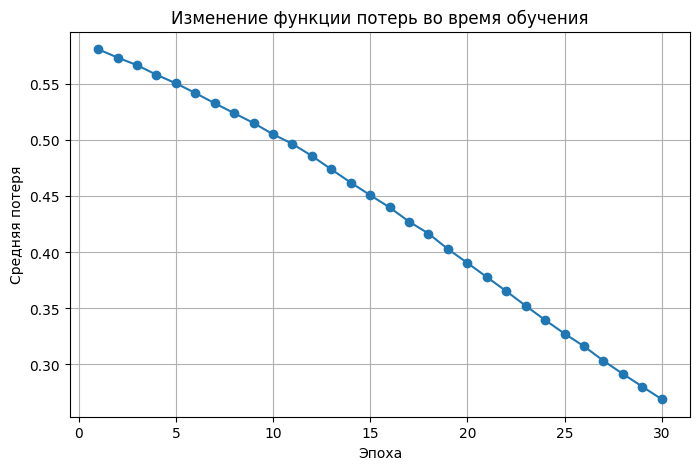

In [16]:
# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-')
plt.title("Изменение функции потерь во время обучения")
plt.xlabel("Эпоха")
plt.ylabel("Средняя потеря")
plt.grid(True)
plt.show()

In [25]:
embeddings = model.embedding.weight.detach()
print("Размерность матрицы эмбеддингов:", embeddings.shape)


Размерность матрицы эмбеддингов: torch.Size([41, 32])


In [18]:
word = "positive"
if word in vocab:
    word_index = vocab[word]
    word_embedding = embeddings[word_index]
    print(f"Эмбеддинг для слова '{word}':\n", word_embedding)
else:
    print(f"Слово '{word}' отсутствует в словаре.")

Эмбеддинг для слова 'positive':
 tensor([ 1.5621,  1.5980,  1.3158,  1.3783, -0.6791,  1.4241, -0.3903, -0.0183,
        -0.2911, -1.1232,  0.4488,  0.2894,  1.3158, -0.7938,  1.5406, -0.0833,
        -0.4578, -0.6905,  0.2576,  2.8942, -0.2629, -0.4030,  1.6220, -1.1876,
         0.0088, -2.1884, -0.6091,  0.2266,  0.6359,  1.1358, -1.6528, -0.0795])


In [22]:
word1 = "positive"
word2 = "negative"

if word1 in vocab and word2 in vocab:
    index1 = vocab[word1]
    index2 = vocab[word2]
    embedding1 = embeddings[index1]
    embedding2 = embeddings[index2]
    
    similarity = cosine_similarity(embedding1, embedding2)
    print(f"Косинусное сходство между '{word1}' и '{word2}': {similarity:.4f}")
else:
    print(f"Одно из слов ('{word1}', '{word2}') отсутствует в словаре.")

Косинусное сходство между 'positive' и 'negative': -0.0763


In [27]:
word1 = "negative"
word2 = "awful"

if word1 in vocab and word2 in vocab:
    index1 = vocab[word1]
    index2 = vocab[word2]
    embedding1 = embeddings[index1]
    embedding2 = embeddings[index2]
    
    similarity = cosine_similarity(embedding1, embedding2)
    print(f"Косинусное сходство между '{word1}' и '{word2}': {similarity:.4f}")
else:
    print(f"Одно из слов ('{word1}', '{word2}') отсутствует в словаре.")

Косинусное сходство между 'negative' и 'awful': 0.1280
